# Meter Reading Imputing
- Replace NaN's 
    - If number of consecutive NaN's < 3: use neighboring values
    - If number of consecutive NaN's > 3: calculate average hourly value per season for each building, and use corresponding value


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import pickle

pd.set_option('display.max_columns', None)

In [3]:
%matplotlib inline

import sys
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
with open('berkeley_matched_readings.pkl','rb') as read_file:
    berkeley_df = pickle.load(read_file)

In [4]:
berkeley_df = berkeley_df.sort_values(by=['building_id', 'timestamp']).reset_index(drop=True)

In [5]:
berkeley_df

,building_id,timestamp,meter_reading_scraped
0,565,2016-01-01 00:00:00,8.0
1,565,2016-01-01 01:00:00,7.0
2,565,2016-01-01 02:00:00,8.0
3,565,2016-01-01 03:00:00,8.0
4,565,2016-01-01 04:00:00,8.0
...,...,...,...
2539675,655,2019-11-30 19:00:00,127.0
2539676,655,2019-11-30 20:00:00,125.0
2539677,655,2019-11-30 21:00:00,121.0
2539678,655,2019-11-30 22:00:00,123.0


### Add date, year, month, hour, day columns

In [6]:
berkeley_time = [str(rows) for index, rows in berkeley_df['timestamp'].iteritems()]    

In [7]:
# Function that converts timestamp to datetime, then creates hour, day, month, and date series

def to_datetime(time_list):

    new_time_list = []

    for i in time_list:
        i = i.strip()
        new_time_list.append(dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S'))
    
    hours = pd.Series(new_time_list).dt.hour
    days = pd.Series(new_time_list).dt.day
    months = pd.Series(new_time_list).dt.month
    years = pd.Series(new_time_list).dt.year
    date = pd.Series(new_time_list).dt.date
    
    return new_time_list, hours, days, months, years, date

In [8]:
berkeley_new_time, berkeley_hours, berkeley_days, berkeley_months, berkeley_years, berkeley_date = to_datetime(berkeley_time)



In [9]:
berkeley_df['timestamp'] = berkeley_new_time

In [10]:
berkeley_df.insert(2, column = 'Date', value = berkeley_date)
berkeley_df.insert(3, column = 'Year', value = berkeley_years)
berkeley_df.insert(4, column = 'Month', value = berkeley_months)
berkeley_df.insert(5, column = 'Day', value = berkeley_days)
berkeley_df.insert(6, column = 'Hour', value = berkeley_hours)

### Add Season Column

In [11]:
# Create and add season column:

def season_helper(month):
    if month in [12, 1, 2]:
        return 'Winter'
    if month in [3, 4, 5]:
        return 'Spring'
    if month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'


In [12]:
berkeley_df.insert(3, column = 'Season', value = berkeley_df['Month'].apply(season_helper))


In [13]:
berkeley_df['meter_reading_scraped'].isna().value_counts()

False    2492642
True       47038
Name: meter_reading_scraped, dtype: int64

In [14]:
# with open('berkeley_dates_raw.pkl', 'wb') as to_write:
#     pickle.dump(berkeley_df, to_write)

---

### Load in small_na_series
- Per Meter_Reading_Imputing_R1.ipynb, berkeley_df was searched to find where number of consecutive NaN metering reading values was less than 10
- small_na_series contains replacement values for these particular NaN's

In [65]:
with open('berkeley_dates_raw.pkl','rb') as read_file:
    berkeley_df = pickle.load(read_file)

In [66]:
with open('small_na_series.pkl','rb') as read_file:
    small_na_series = pickle.load(read_file)

In [67]:
berkeley_df.meter_reading_scraped.isna().value_counts()

False    2492642
True       47038
Name: meter_reading_scraped, dtype: int64

In [68]:
berkeley_df.loc[small_na_series.index, 'meter_reading_scraped'] = small_na_series.values


In [69]:
berkeley_df.meter_reading_scraped.isna().value_counts()

False    2492664
True       47016
Name: meter_reading_scraped, dtype: int64

### Shift timestamps to match Daylight Savings
- To avoid 1:00 AM from being abnormally high, those values will be shifted to 1:30 AM

In [71]:
berkeley_df['Hour'].value_counts()

1     106116
23    105820
22    105820
3     105820
4     105820
5     105820
6     105820
7     105820
8     105820
9     105820
10    105820
11    105820
12    105820
13    105820
14    105820
15    105820
16    105820
17    105820
18    105820
19    105820
20    105820
21    105820
0     105820
2     105524
Name: Hour, dtype: int64

In [72]:
berkeley_df = berkeley_df.sort_values(by=['timestamp', 'building_id']).reset_index(drop=True)

In [73]:
berkeley_df['timestamp'].value_counts()

2018-11-04 01:00:00    148
2019-11-03 01:00:00    148
2017-11-05 01:00:00    148
2016-11-06 01:00:00    148
2016-04-27 15:00:00     74
                      ... 
2019-10-20 16:00:00     74
2016-03-24 03:00:00     74
2018-05-13 09:00:00     74
2017-03-10 04:00:00     74
2017-08-10 14:00:00     74
Name: timestamp, Length: 34316, dtype: int64

In [74]:
dst_2016 = berkeley_df[berkeley_df['timestamp'] == '2016-11-06 01:00:00'][1::2]['timestamp']
dst_2017 = berkeley_df[berkeley_df['timestamp'] == '2017-11-05 01:00:00'][1::2]['timestamp']
dst_2018 = berkeley_df[berkeley_df['timestamp'] == '2018-11-04 01:00:00'][1::2]['timestamp']
dst_2019 = berkeley_df[berkeley_df['timestamp'] == '2019-11-03 01:00:00'][1::2]['timestamp']

In [75]:
dst = dst_2016.append(dst_2017)
dst = dst.append(dst_2018)
dst = dst.append(dst_2019)

In [76]:
dst = dst + timedelta(hours = 0.5)

In [77]:
dst

550561    2016-11-06 01:30:00
550563    2016-11-06 01:30:00
550565    2016-11-06 01:30:00
550567    2016-11-06 01:30:00
550569    2016-11-06 01:30:00
                  ...        
2490091   2019-11-03 01:30:00
2490093   2019-11-03 01:30:00
2490095   2019-11-03 01:30:00
2490097   2019-11-03 01:30:00
2490099   2019-11-03 01:30:00
Name: timestamp, Length: 296, dtype: datetime64[ns]

In [78]:
berkeley_df.loc[dst.index, 'timestamp'] = dst.values

In [84]:
# with open('berkeley_part_clean2.pkl', 'wb') as to_write:
#     pickle.dump(berkeley_df, to_write)

## Find mean values for meter readings
- Find means at each building for each hour in each season
- Only look at 2016-2018, since this training data only consists of data from these years

In [85]:
berkeley_df = berkeley_df.sort_values(by=['building_id', 'timestamp']).reset_index(drop=True)
berkeley_df

,building_id,timestamp,Date,Year,Season,Month,Day,Hour,meter_reading_scraped
0,565,2016-01-01 00:00:00,2016-01-01,2016,Winter,1,1,0,8.0
1,565,2016-01-01 01:00:00,2016-01-01,2016,Winter,1,1,1,7.0
2,565,2016-01-01 02:00:00,2016-01-01,2016,Winter,1,1,2,8.0
3,565,2016-01-01 03:00:00,2016-01-01,2016,Winter,1,1,3,8.0
4,565,2016-01-01 04:00:00,2016-01-01,2016,Winter,1,1,4,8.0
...,...,...,...,...,...,...,...,...,...
2539675,655,2019-11-30 19:00:00,2019-11-30,2019,Fall,11,30,19,127.0
2539676,655,2019-11-30 20:00:00,2019-11-30,2019,Fall,11,30,20,125.0
2539677,655,2019-11-30 21:00:00,2019-11-30,2019,Fall,11,30,21,121.0
2539678,655,2019-11-30 22:00:00,2019-11-30,2019,Fall,11,30,22,123.0


In [87]:
berkeley_df = berkeley_df[berkeley_df['Year'] < 2019]

In [88]:
# Split dataframe by the 74 buidlings.

def building_df_separator(full_df, building_no):
    
    building_df = full_df[full_df['building_id'] == building_no]
        
    return building_df

In [89]:
building_list = berkeley_df['building_id'].unique()

In [90]:
building_list

array([565, 567, 568, 569, 570, 571, 573, 574, 575, 576, 577, 580, 582,
       583, 584, 585, 586, 587, 588, 589, 592, 594, 595, 597, 598, 599,
       600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
       614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 626, 627,
       628, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 641, 642,
       643, 644, 645, 646, 649, 652, 653, 654, 655])

In [91]:
# building_dict key: building number
# building_dict value: buidling's berkeley dataframe

building_dict = {}

for i in building_list:
    building_dict[i] = building_df_separator(berkeley_df, i)


In [92]:
building_dict[565].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26304 entries, 0 to 26303
Data columns (total 9 columns):
building_id              26304 non-null int32
timestamp                26304 non-null datetime64[ns]
Date                     26304 non-null object
Year                     26304 non-null int64
Season                   26304 non-null object
Month                    26304 non-null int64
Day                      26304 non-null int64
Hour                     26304 non-null int64
meter_reading_scraped    26304 non-null float64
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4), object(2)
memory usage: 1.9+ MB


In [93]:
meter_columns = ['meter_reading_scraped']

In [94]:
# For meter reading at each building, find average hourly value per season.
# mean_df is a building specific dataframe containing all meter readings during a specific season at a specific hour.
# means_dict keys contain info about the meter, season, and hour.  means_dict values are the averages for the values in the specified mean_df.

def column_means(dataframe):
    
    means_dict = {}
    
    for feature in meter_columns:
        for month in dataframe['Season'].unique():
            for hour in dataframe['Hour'].unique():
                mean_df = dataframe[['Season', 'Hour', feature]][(dataframe['Hour'] == hour) & (dataframe['Season'] == month)]
                means_dict[feature, month, hour] = np.mean(mean_df[feature])
               
    return means_dict    
        

In [95]:
building_dict[565]

,building_id,timestamp,Date,Year,Season,Month,Day,Hour,meter_reading_scraped
0,565,2016-01-01 00:00:00,2016-01-01,2016,Winter,1,1,0,8.0
1,565,2016-01-01 01:00:00,2016-01-01,2016,Winter,1,1,1,7.0
2,565,2016-01-01 02:00:00,2016-01-01,2016,Winter,1,1,2,8.0
3,565,2016-01-01 03:00:00,2016-01-01,2016,Winter,1,1,3,8.0
4,565,2016-01-01 04:00:00,2016-01-01,2016,Winter,1,1,4,8.0
...,...,...,...,...,...,...,...,...,...
26299,565,2018-12-31 19:00:00,2018-12-31,2018,Winter,12,31,19,3.0
26300,565,2018-12-31 20:00:00,2018-12-31,2018,Winter,12,31,20,4.0
26301,565,2018-12-31 21:00:00,2018-12-31,2018,Winter,12,31,21,3.0
26302,565,2018-12-31 22:00:00,2018-12-31,2018,Winter,12,31,22,3.0


In [96]:
# berkeley_means_dict contains all average meter reading values for each hour and season.
# keys are the building, values are the average values.

berkeley_means_dict = {}

for i in building_list:
    berkeley_means_dict[i] = column_means(building_dict[i])

### Fill NaN values with appropriate mean values

In [97]:
# Replace nan values with -100 so they can be called in the fill_na_means function.

building_clean_dict = {}

for i in building_list:
    building_clean_dict[i] = building_dict[i].fillna(-100)

In [98]:
building_clean_dict[655]

,building_id,timestamp,Date,Year,Season,Month,Day,Hour,meter_reading_scraped
2505360,655,2016-01-01 00:00:00,2016-01-01,2016,Winter,1,1,0,67.0
2505361,655,2016-01-01 01:00:00,2016-01-01,2016,Winter,1,1,1,66.0
2505362,655,2016-01-01 02:00:00,2016-01-01,2016,Winter,1,1,2,66.0
2505363,655,2016-01-01 03:00:00,2016-01-01,2016,Winter,1,1,3,66.0
2505364,655,2016-01-01 04:00:00,2016-01-01,2016,Winter,1,1,4,64.0
...,...,...,...,...,...,...,...,...,...
2531659,655,2018-12-31 19:00:00,2018-12-31,2018,Winter,12,31,19,59.0
2531660,655,2018-12-31 20:00:00,2018-12-31,2018,Winter,12,31,20,57.0
2531661,655,2018-12-31 21:00:00,2018-12-31,2018,Winter,12,31,21,58.0
2531662,655,2018-12-31 22:00:00,2018-12-31,2018,Winter,12,31,22,58.0


In [99]:
# For each nan value (now -100), match its index with the corresponding average value.

def fill_na_means(dataframe, means_dict):
    
    means_list = []
    
    for index, rows in dataframe.iterrows():
        for feature in meter_columns:
            for month in dataframe['Season'].unique():
                for hour in dataframe['Hour'].unique():
                    if rows['Season'] == month:
                        if rows['Hour'] == hour:
                            if rows[feature] == -100:
                                means_list.append((index, feature, means_dict[feature, month, hour]))
    
    return means_list

In [100]:
# means_ind_dict contains all values in each column that are replaced nan values.
# means_ind_dict keys are building number, values are lists of tuples containing the index of the value and the average meter reading value.

means_ind_dict = {}

for i in building_list:
    means_ind_dict[i] = fill_na_means(building_clean_dict[i], berkeley_means_dict[i])

In [101]:
# for index, rows in weather_df.iterrows():
#     for keys, values in means_ind_dict.items():
#         if index == values[0] and rows == values[1]:
#             rows[values1] = rows[values1].replace(values[2], inplace = True)


In [102]:
# Separate means_ind_dict into lists for each measurement.  Lists will contain index and average values.

meter_reading_list = []

for keys, values in means_ind_dict.items():
    for mean in values:
        if mean[1] == 'meter_reading_scraped':
            meter_reading_list.append([mean[0], mean[2]])         
    

In [103]:
# Convert each list into a series (with index intact) and combine into mean_series_dict
# so that each series can be called into berkeley_df.
# mean_series_dict keys correspond to the meter_reading_list, values correspond to 
# average values that replaced nan values.

means_list = [meter_reading_list]

mean_series_dict = {}

for index, lists in enumerate(means_list):
    mean_series_dict[index] = pd.Series([i[1] for i in lists], index = [i[0] for i in lists])
    

In [104]:
# Create new column in berkeley_df for each mean series in mean_series_dict
# (with index intact).

berkeley_df[meter_columns[0] + '_mean'] = mean_series_dict[0]

/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [105]:
berkeley_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946496 entries, 0 to 2531663
Data columns (total 10 columns):
building_id                   int32
timestamp                     datetime64[ns]
Date                          object
Year                          int64
Season                        object
Month                         int64
Day                           int64
Hour                          int64
meter_reading_scraped         float64
meter_reading_scraped_mean    float64
dtypes: datetime64[ns](1), float64(2), int32(1), int64(4), object(2)
memory usage: 155.9+ MB


In [106]:
# Replace nan values in berkeley_df with average values from corresponding mean columns. 

for feature in meter_columns:
    berkeley_df[feature] = berkeley_df[feature].fillna(berkeley_df[feature + '_mean'])
    

/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [108]:
# Remove mean columns from berkeley_df.

del berkeley_df['meter_reading_scraped_mean']

In [109]:
berkeley_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946496 entries, 0 to 2531663
Data columns (total 9 columns):
building_id              int32
timestamp                datetime64[ns]
Date                     object
Year                     int64
Season                   object
Month                    int64
Day                      int64
Hour                     int64
meter_reading_scraped    float64
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4), object(2)
memory usage: 141.1+ MB


In [111]:
# with open('berkeley18_clean.pkl', 'wb') as to_write:
#     pickle.dump(berkeley_df, to_write)

### Fill in 2019 NaNs with 2016-2018 means

In [120]:
with open('berkeley_part_clean2.pkl','rb') as read_file:
    berkeley19_df = pickle.load(read_file)

In [121]:
berkeley19_df = berkeley19_df[berkeley19_df['Year'] > 2018]

In [134]:
berkeley19_df[berkeley19_df['meter_reading_scraped'].isna() == True]


,building_id,timestamp,Date,Year,Season,Month,Day,Hour,meter_reading_scraped
99862,568,2019-07-24 23:00:00,2019-07-24,2019,Summer,7,24,23,NaN
99863,568,2019-07-25 00:00:00,2019-07-25,2019,Summer,7,25,0,NaN
101151,568,2019-09-16 16:00:00,2019-09-16,2019,Fall,9,16,16,NaN
101152,568,2019-09-16 17:00:00,2019-09-16,2019,Fall,9,16,17,NaN
101153,568,2019-09-16 18:00:00,2019-09-16,2019,Fall,9,16,18,NaN
...,...,...,...,...,...,...,...,...,...
2291528,644,2019-01-05 08:00:00,2019-01-05,2019,Winter,1,5,8,NaN
2291529,644,2019-01-05 09:00:00,2019-01-05,2019,Winter,1,5,9,NaN
2291530,644,2019-01-05 10:00:00,2019-01-05,2019,Winter,1,5,10,NaN
2291531,644,2019-01-05 11:00:00,2019-01-05,2019,Winter,1,5,11,NaN


In [124]:
# building_dict key: building number
# building_dict value: buidling's berkeley dataframe

building19_dict = {}

for i in building_list:
    building19_dict[i] = building_df_separator(berkeley19_df, i)

In [125]:
# Replace nan values with -100 so they can be called in the fill_na_means function.

building19_clean_dict = {}

for i in building_list:
    building19_clean_dict[i] = building19_dict[i].fillna(-100)

In [126]:
# means_ind_dict contains all values in each column that are replaced nan values.
# means_ind_dict keys are building number, values are lists of tuples containing the index of the value and the average meter reading value.

means19_ind_dict = {}

for i in building_list:
    means19_ind_dict[i] = fill_na_means(building19_clean_dict[i], berkeley_means_dict[i])

In [136]:
means19_ind_dict[644]

[(2291528, 'meter_reading_scraped', 232.1798139114391),
 (2291529, 'meter_reading_scraped', 240.53322487084873),
 (2291530, 'meter_reading_scraped', 246.98028741697416),
 (2291531, 'meter_reading_scraped', 250.8452871851852),
 (2291532, 'meter_reading_scraped', 253.3319639483395)]

In [127]:
# Separate means_ind_dict into lists for each measurement.  Lists will contain index and average values.

meter19_reading_list = []

for keys, values in means19_ind_dict.items():
    for mean in values:
        if mean[1] == 'meter_reading_scraped':
            meter19_reading_list.append([mean[0], mean[2]])         
    

In [138]:
len(meter19_reading_list)

14848

In [139]:
# Convert each list into a series (with index intact) and combine into mean_series_dict
# so that each series can be called into berkeley19_df.
# mean19_series_dict keys correspond to the meter_reading_list, values correspond to 
# average values that replaced nan values.

means_list = [meter19_reading_list]

mean19_series_dict = {}

for index, lists in enumerate(means_list):
    mean19_series_dict[index] = pd.Series([i[1] for i in lists], index = [i[0] for i in lists])
    

In [140]:
# Create new column in berkeley19_df for each mean series in mean19_series_dict
# (with index intact).

berkeley19_df[meter_columns[0] + '_mean'] = mean19_series_dict[0]

In [141]:
berkeley19_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 593184 entries, 26304 to 2539679
Data columns (total 10 columns):
building_id                   593184 non-null int32
timestamp                     593184 non-null datetime64[ns]
Date                          593184 non-null object
Year                          593184 non-null int64
Season                        593184 non-null object
Month                         593184 non-null int64
Day                           593184 non-null int64
Hour                          593184 non-null int64
meter_reading_scraped         578336 non-null float64
meter_reading_scraped_mean    14848 non-null float64
dtypes: datetime64[ns](1), float64(2), int32(1), int64(4), object(2)
memory usage: 47.5+ MB


In [142]:
# Replace nan values in berkeley19_df with average values from corresponding mean columns. 

for feature in meter_columns:
    berkeley19_df[feature] = berkeley19_df[feature].fillna(berkeley19_df[feature + '_mean'])
    

In [143]:
# Remove mean columns from berkeley19_df.

del berkeley19_df['meter_reading_scraped_mean']

In [144]:
berkeley19_df.meter_reading_scraped.isna().value_counts()

False    593184
Name: meter_reading_scraped, dtype: int64

### Append berkeley19_df to rest of berkeley_df

In [145]:
with open('berkeley18_clean.pkl','rb') as read_file:
    berkeley18_df = pickle.load(read_file)

In [146]:
berkeley18_df

,building_id,timestamp,Date,Year,Season,Month,Day,Hour,meter_reading_scraped
0,565,2016-01-01 00:00:00,2016-01-01,2016,Winter,1,1,0,8.0
1,565,2016-01-01 01:00:00,2016-01-01,2016,Winter,1,1,1,7.0
2,565,2016-01-01 02:00:00,2016-01-01,2016,Winter,1,1,2,8.0
3,565,2016-01-01 03:00:00,2016-01-01,2016,Winter,1,1,3,8.0
4,565,2016-01-01 04:00:00,2016-01-01,2016,Winter,1,1,4,8.0
...,...,...,...,...,...,...,...,...,...
2531659,655,2018-12-31 19:00:00,2018-12-31,2018,Winter,12,31,19,59.0
2531660,655,2018-12-31 20:00:00,2018-12-31,2018,Winter,12,31,20,57.0
2531661,655,2018-12-31 21:00:00,2018-12-31,2018,Winter,12,31,21,58.0
2531662,655,2018-12-31 22:00:00,2018-12-31,2018,Winter,12,31,22,58.0


In [147]:
berkeley_df = berkeley18_df.append(berkeley19_df)

In [149]:
berkeley_df.meter_reading_scraped.isna().value_counts()

False    2539680
Name: meter_reading_scraped, dtype: int64

## Check for Outliers with box plot

In [150]:
berkeley_df = berkeley_df.sort_values(by=['building_id', 'timestamp']).reset_index(drop=True)

In [151]:
berkeley_df

,building_id,timestamp,Date,Year,Season,Month,Day,Hour,meter_reading_scraped
0,565,2016-01-01 00:00:00,2016-01-01,2016,Winter,1,1,0,8.0
1,565,2016-01-01 01:00:00,2016-01-01,2016,Winter,1,1,1,7.0
2,565,2016-01-01 02:00:00,2016-01-01,2016,Winter,1,1,2,8.0
3,565,2016-01-01 03:00:00,2016-01-01,2016,Winter,1,1,3,8.0
4,565,2016-01-01 04:00:00,2016-01-01,2016,Winter,1,1,4,8.0
...,...,...,...,...,...,...,...,...,...
2539675,655,2019-11-30 19:00:00,2019-11-30,2019,Fall,11,30,19,127.0
2539676,655,2019-11-30 20:00:00,2019-11-30,2019,Fall,11,30,20,125.0
2539677,655,2019-11-30 21:00:00,2019-11-30,2019,Fall,11,30,21,121.0
2539678,655,2019-11-30 22:00:00,2019-11-30,2019,Fall,11,30,22,123.0


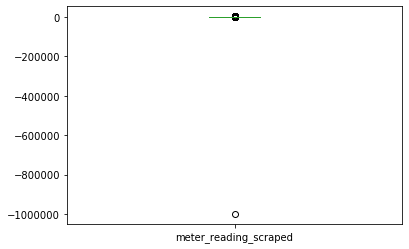

In [152]:
berkeley_df['meter_reading_scraped'].plot.box()

In [153]:
meter_readings = berkeley_df['meter_reading_scraped']

q25, q50, q75 = np.percentile(meter_readings, [25, 50, 75])
iqr = q75 - q25

min = q25 - 1.5*iqr
max = q75 + 1.5*iqr

In [154]:
outlier_index = []
outlier_list = []

for index, row in meter_readings.iteritems():
    if row > max or row < min:
        outlier_index.append(index)
        outlier_list.append([index, row])

In [155]:
len(outlier_list)

226176

### Biggest outlier occurs on 07/16/2019

In [156]:
berkeley_df.loc[outlier_index]

,building_id,timestamp,Date,Year,Season,Month,Day,Hour,meter_reading_scraped
117682,569,2017-09-05 11:00:00,2017-09-05,2017,Fall,9,5,11,520.0000
117683,569,2017-09-05 12:00:00,2017-09-05,2017,Fall,9,5,12,528.0000
117684,569,2017-09-05 13:00:00,2017-09-05,2017,Fall,9,5,13,531.0000
117685,569,2017-09-05 14:00:00,2017-09-05,2017,Fall,9,5,14,525.0000
117686,569,2017-09-05 15:00:00,2017-09-05,2017,Fall,9,5,15,525.0000
...,...,...,...,...,...,...,...,...,...
2471035,653,2019-11-30 19:00:00,2019-11-30,2019,Fall,11,30,19,674.0000
2471036,653,2019-11-30 20:00:00,2019-11-30,2019,Fall,11,30,20,658.0011
2471037,653,2019-11-30 21:00:00,2019-11-30,2019,Fall,11,30,21,655.0022
2471038,653,2019-11-30 22:00:00,2019-11-30,2019,Fall,11,30,22,659.0000


In [157]:
berkeley_df[berkeley_df['timestamp'] == '2019-07-16 08:00:00'].head(10)

,building_id,timestamp,Date,Year,Season,Month,Day,Hour,meter_reading_scraped
31015,565,2019-07-16 08:00:00,2019-07-16,2019,Summer,7,16,8,13.00000
65335,567,2019-07-16 08:00:00,2019-07-16,2019,Summer,7,16,8,186.63275
99655,568,2019-07-16 08:00:00,2019-07-16,2019,Summer,7,16,8,8.19000
133975,569,2019-07-16 08:00:00,2019-07-16,2019,Summer,7,16,8,328.00000
168295,570,2019-07-16 08:00:00,2019-07-16,2019,Summer,7,16,8,176.25600
202615,571,2019-07-16 08:00:00,2019-07-16,2019,Summer,7,16,8,66.00000
236935,573,2019-07-16 08:00:00,2019-07-16,2019,Summer,7,16,8,-999983.60000
271255,574,2019-07-16 08:00:00,2019-07-16,2019,Summer,7,16,8,50.00000
305575,575,2019-07-16 08:00:00,2019-07-16,2019,Summer,7,16,8,53.00000
339895,576,2019-07-16 08:00:00,2019-07-16,2019,Summer,7,16,8,248.00000


### Manually change value based on surrounding values

In [158]:
berkeley_df.loc[236935, 'meter_reading_scraped'] = 7.50

In [159]:
berkeley_df.loc[236935]

building_id                              573
timestamp                2019-07-16 08:00:00
Date                              2019-07-16
Year                                    2019
Season                                Summer
Month                                      7
Day                                       16
Hour                                       8
meter_reading_scraped                    7.5
Name: 236935, dtype: object

In [160]:
# with open('berkeley_clean4.pkl', 'wb') as to_write:
#     pickle.dump(berkeley_df, to_write)